In [1]:
from langgraph.graph import StateGraph, START, END, MessagesState
from pydantic import BaseModel, Field
# the following includes will allow you display graph diagrams in Jupyter workbook
from IPython.display import display, Image

In [2]:
class MyState(BaseModel):
    messages: list[str]

In [28]:
def bm25(state: MyState) -> dict:
    # Dummy BM25 function for illustration
    return {"messages": state.messages + ["Hello from bm25"]}

def sbert(state: MyState) -> dict:
    # Dummy BM25 function for illustration
    return {"messages": state.messages + ["Hello from sbert"]}

def image(state: MyState) -> dict:
    # Dummy BM25 function for illustration
    return {"messages": state.messages + ["Hello from image"]}

def voice(state: MyState) -> dict:
    # Dummy BM25 function for illustration
    return {"messages": state.messages + ["Hello from voice"]}

def text(state: MyState) -> dict:
    # Dummy BM25 function for illustration
    return {"messages": state.messages + ["Hello from text"]}

def hybrid(state: MyState) -> dict:
    # Dummy BM25 function for illustration
    return {"messages": state.messages + ["Hello from hybrid"]}

def ranked(state: MyState) -> dict:
    # Dummy BM25 function for illustration
    return {"messages": state.messages + ["Hello from ranked"]}

In [3]:
def node1(state: MyState) -> dict:
    print("Node 1")

    return {"messages": state.messages + ["Hello from Node 1"]}

def node2(state: MyState) -> dict:

    print("Node 2")

    return {"messages": state.messages + ["Hello from Node 2"]}

def node3(state: MyState) -> dict:

    print("Node 3")

    return {"messages": state.messages + ["Hello from Node 3"] }

In [4]:
# create th graph, passing the state class
graph = StateGraph(MyState)

# add nodes to the graph
graph.add_node("node1", node1)
graph.add_node("node2", node2)
graph.add_node("node3", node3)

# add edges to the graph
graph.add_edge(START, "node1")
graph.add_edge("node1", "node2")
graph.add_edge("node2", "node3")
graph.add_edge("node3", END)

# compile the graph
compiled_graph = graph.compile()

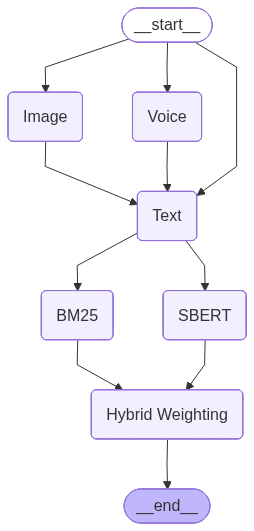

In [35]:
search_graph = StateGraph(MyState)

# add nodes to the graph
search_graph.add_node("BM25", bm25)
search_graph.add_node("SBERT", sbert)
search_graph.add_node("Image", image)
search_graph.add_node("Voice", voice)
search_graph.add_node("Text", text)
search_graph.add_node("Hybrid Weighting", hybrid)



# add edges to the graph
search_graph.add_edge(START, "Image")
search_graph.add_edge(START, "Voice")
search_graph.add_edge(START, "Text")
search_graph.add_edge("Image", "Text")
search_graph.add_edge("Voice", "Text")


search_graph.add_edge("Text", "SBERT")
search_graph.add_edge("Text", "BM25")
search_graph.add_edge("SBERT", "Hybrid Weighting")
search_graph.add_edge("BM25", "Hybrid Weighting")
search_graph.add_edge("Hybrid Weighting", END)


compiled_search_graph = search_graph.compile()

compiled_search_graph

In [36]:
print(compiled_search_graph.get_graph().draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	BM25(BM25)
	SBERT(SBERT)
	Image(Image)
	Voice(Voice)
	Text(Text)
	Hybrid\20Weighting(Hybrid Weighting)
	__end__([<p>__end__</p>]):::last
	BM25 --> Hybrid\20Weighting;
	Image --> Text;
	SBERT --> Hybrid\20Weighting;
	Text --> BM25;
	Text --> SBERT;
	Voice --> Text;
	__start__ --> Image;
	__start__ --> Text;
	__start__ --> Voice;
	Hybrid\20Weighting --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



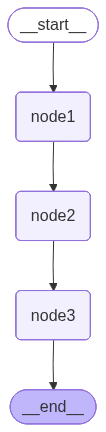

In [5]:
compiled_graph

In [6]:
# run the graph
result = compiled_graph.invoke(MyState(messages=[]))
print("Final State: ", result)

Node 1
Node 2
Node 3
Final State:  {'messages': ['Hello from Node 1', 'Hello from Node 2', 'Hello from Node 3']}


In [7]:
class MyState2(BaseModel):
    messages: list[str]

graph = StateGraph(MyState2)
graph.add_node("node1", node1)
graph.add_node("node2", node2)
graph.add_node("node3", node3)
graph.add_edge(START, "node1")
graph.add_edge("node1", "node2")
graph.add_edge("node1", "node3")
graph.add_edge("node2", END)
compiled_graph = graph.compile()

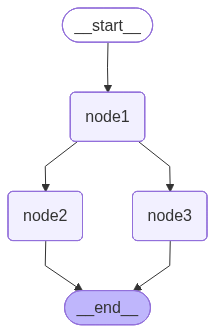

In [8]:
Image(compiled_graph.get_graph().draw_mermaid_png())

In [9]:
# run the graph. You will get an error
#result = compiled_graph.invoke(MyState(messages=[]))
#print("Final State: ", result)

In [10]:
from typing import Annotated
from langgraph.graph.message import add_messages

In [11]:
def string_list_reducer(left: list[str], right: list[str])->list[str]:
    return left + right

In [12]:
class MyState3(BaseModel):
    messages: Annotated[list, string_list_reducer]

In [13]:
def node1(state: MyState3) -> dict:

    print("Node 1")

    return {"messages": ["Hello from Node 1"] }

def node2(state: MyState3) -> dict:

    print("Node 2")

    return {"messages": ["Hello from Node 2"]}

def node3(state: MyState3) -> dict:

    print("Node 3")

    return {"messages": ["Hello from Node 3"]}

In [14]:
graph = StateGraph(MyState3)
graph.add_node("node1", node1)
graph.add_node("node2", node2)
graph.add_node("node3", node3)
graph.add_edge(START, "node1")
graph.add_edge("node1", "node2")
graph.add_edge("node1", "node3")
graph.add_edge("node2", END)
compiled_graph = graph.compile()

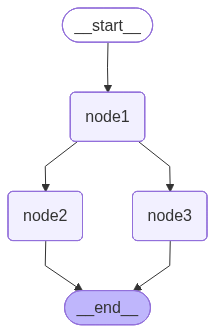

In [15]:
Image(compiled_graph.get_graph().draw_mermaid_png())

In [16]:
# run the graph.
result = compiled_graph.invoke(MyState3(messages=[]))
print("Final State: ", result)

Node 1
Node 2
Node 3
Final State:  {'messages': ['Hello from Node 1', 'Hello from Node 2', 'Hello from Node 3']}


In [17]:
def random_node(state: MyState3) -> dict:

    # create a random boolean value

    import random

    random_value = str(random.choice([True, False]))

    print(f"random node: random_value = {random_value}")

    return {"messages": [random_value]}

In [18]:
def conditional_edge(state: MyState3) -> str:

    # Check the content of the last message in the state

    if state.messages[-1] == "True":
        return "node2"
    else:
        return "node3"

In [19]:
graph = StateGraph(MyState3)
graph.add_node("random_node", random_node)
graph.add_node("node2", node2)
graph.add_node("node3", node3)
# edges
graph.add_edge(START, "random_node")
graph.add_conditional_edges("random_node", conditional_edge)
graph.add_edge("node2", END)
graph.add_edge("node3", END)
# compile the graph
compiled_graph = graph.compile()

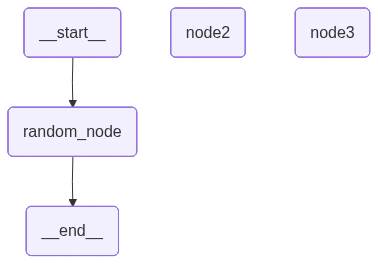

In [20]:
Image(compiled_graph.get_graph().draw_mermaid_png())

In [21]:
result = compiled_graph.invoke(MyState3(messages=[]))

random node: random_value = True
Node 2


In [22]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import (HumanMessage, SystemMessage, AIMessage, ToolMessage, AnyMessage )
import os
from dotenv import load_dotenv

/home/aidodo/Foundations_of_AgenticAI/agentic-labs/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [23]:
load_dotenv()

True

In [24]:
model = ChatGoogleGenerativeAI(model=os.getenv("GOOGLE_API_MODEL"),temperature=0)

E0000 00:00:1761813753.593008    5359 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [25]:
class MyMessagesState(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages]

In [26]:
def llm_node(state: MyMessagesState) -> dict:
    
    response = model.invoke(state.messages)

    return {"messages": response}

In [27]:
graph = StateGraph(MyMessagesState)
graph.add_node("llm_node", llm_node)
graph.add_edge(START, "llm_node")
graph.add_edge("llm_node", END)
compiled_graph = graph.compile()

In [28]:
user_message = HumanMessage(content="What is the capital of France?")
result = compiled_graph.invoke(MyMessagesState(messages=[user_message]))
print(result)

{'messages': [HumanMessage(content='What is the capital of France?', additional_kwargs={}, response_metadata={}, id='2b84ad25-93f5-4249-b706-f437c5d148c1'), AIMessage(content='The capital of France is **Paris**.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': []}, id='run--bc04e9aa-fda7-45c2-a97c-40992a84844f-0', usage_metadata={'input_tokens': 8, 'output_tokens': 8, 'total_tokens': 16, 'input_token_details': {'cache_read': 0}})]}


In [29]:
result['messages'][-1].content

'The capital of France is **Paris**.'

In [30]:
class Result(BaseModel):

    capital: str = Field(..., description="The capital city of the given country.")

    population: int = Field(..., description="The population of the given country.")

In [31]:
# create structured_ouptut runnable for the model
structured_llm = model.with_structured_output(Result)

In [32]:
class StructuredState(BaseModel):

    result: Result = None

    input: str

In [33]:
def structure_node(state: StructuredState) -> dict:

    msgs = [HumanMessage(content=state.input)]

    response = structured_llm.invoke(msgs)

    return {"result": response}

In [34]:
result = structured_llm.invoke('What is the capital of France?')
print(result)

capital='Paris' population=65300000


In [35]:
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool

In [36]:
@tool
def read_file_tool(file_path: str) -> str:

    """ Read the contents of a file given its file path. """

    with open(file_path, 'r') as file:

        return file.read()

In [37]:
@tool
def write_file_tool(text: str, file_name: str) -> str:
    
    """ Save text to a file with a given file name and return the file name. """
    import uuid
    str(uuid.uuid4()) + '.txt'
    file_name = file_name + '_' + str(uuid.uuid4()) + '.txt'
    try:
        with open(file_name, 'w', encoding='utf-8') as f:
            f.write(text)
        return file_name
    except Exception as e:
        print(f"Error saving file: {e}")


In [38]:
tools = [read_file_tool, write_file_tool]
tool_model = model.bind_tools(tools)

In [39]:
# llm node
def llm_node_with_tools(state: MyMessagesState) -> dict:

    response = tool_model.invoke(state.messages)

    return {"messages": response}

In [40]:
graph = StateGraph(MyMessagesState)
graph.add_node("llm_node", llm_node_with_tools)
graph.add_node("tool_node", ToolNode(tools))
graph.add_edge(START, "llm_node")
graph.add_edge("llm_node", "tool_node")
graph.add_edge("tool_node", END)
tool_graph = graph.compile()

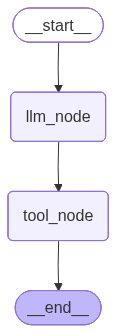

In [41]:
Image(tool_graph.get_graph().draw_mermaid_png())

In [42]:
messages = [ HumanMessage(content="Write the text 'Hello world' to a file with file name 'hello' ")]

result = tool_graph.invoke(MyMessagesState(messages=messages))
print(result['messages'][-1].content)

hello_6ae52cd0-4449-464f-9a31-bdb2c3f82753.txt


In [43]:
def conditional_edge(state: MyMessagesState) -> bool:

    last_message = state.messages[-1]

    return last_message.tool_calls != []

In [44]:
react_graph = StateGraph(MyMessagesState)
react_graph.add_node("llm_node", llm_node_with_tools)
react_graph.add_node("tool_node", ToolNode(tools))
react_graph.add_edge(START, "llm_node")
react_graph.add_conditional_edges("llm_node", conditional_edge,path_map={True: "tool_node", False: END})
react_graph.add_edge("tool_node", "llm_node")

compiled_react_graph = react_graph.compile()

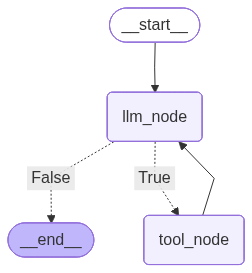

In [45]:
Image(compiled_react_graph.get_graph().draw_mermaid_png())

In [46]:
#messages = [ HumanMessage(content="Write the text 'Hello world' to a file with file name 'hello' ")]
messages = [ HumanMessage(content="Read the contents of the file 'test.txt'. Then summarise the contents. Then write the summary to a file with name 'hello' .")]

result = compiled_react_graph.invoke(MyMessagesState(messages=messages))
print(result['messages'][-1].content)

The contents of 'test.txt' have been summarized and saved to 'hello'.


In [47]:
from typing import Literal, Optional
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage
from pydantic import BaseModel, Field

class CustomerMessage(BaseModel):
    message_type: Literal["sales", "support"] = Field(description="The message type of the customer query i.e. Sales or Support")
    appliance_type: str = Field(description="The type of appliance that the customer is querying.")
    appliance_model: list[str] = Field(description="list of appliances")
    summary: str = Field(description="summary of the customer query")

# create structured_output runnable for the model
structured_llm = model.with_structured_output(CustomerMessage)

class StructuredState(BaseModel):
    messages: list
    # FIX: Use Optional and set default to None properly
    structured_output: Optional[CustomerMessage] = None

def analyseNode(state: StructuredState) -> StructuredState:
    # Use state.messages directly
    response = structured_llm.invoke(state.messages)
    
    # FIX: Return updated state with structured_output
    state.structured_output = response
    return state

def salesNode(state: StructuredState) -> StructuredState:
    print("SALES MESSAGE RECEIVED")
    print(f"Appliance: {state.structured_output.appliance_type}")
    print(f"Models: {state.structured_output.appliance_model}")
    print(f"Summary: {state.structured_output.summary}")
    return state

def supportNode(state: StructuredState) -> StructuredState:
    print("SUPPORT MESSAGE RECEIVED")
    print(f"Appliance: {state.structured_output.appliance_type}")
    print(f"Models: {state.structured_output.appliance_model}")
    print(f"Summary: {state.structured_output.summary}")
    return state

def conditional_edge(state: StructuredState) -> str:
    # Access structured_output as an attribute
    message_type = state.structured_output.message_type
    
    if message_type == "sales":
        return "salesNode"
    else:
        return "supportNode"

graph = StateGraph(StructuredState)
graph.add_node("analyseNode", analyseNode)
graph.add_node("salesNode", salesNode)
graph.add_node("supportNode", supportNode)
graph.add_edge(START, "analyseNode")
graph.add_conditional_edges("analyseNode", conditional_edge, 
                           path_map={"salesNode": "salesNode", "supportNode": "supportNode"})
graph.add_edge("salesNode", END)
graph.add_edge("supportNode", END)
customer_graph = graph.compile()

customer_message = """Hi, I saw your advert for the SmartCool KF3000 fridge and wanted to know if it comes in black as well as silver? Also,is there any current discount or free delivery option available this week?"""

messages = [HumanMessage(content=f"""Analyze the following customer message and extract the requested information:        
CUSTOMER MESSAGE: {customer_message}
Please categorize this message and extract the relevant details.""")]

# FIX: Initialize state correctly
initial_state = StructuredState(
    messages=messages,
    structured_output=None
)

result = customer_graph.invoke(initial_state)

SALES MESSAGE RECEIVED
Appliance: fridge
Models: ['KF3000']
Summary: Customer is asking if the SmartCool KF3000 fridge comes in black and about current discounts or free delivery options.


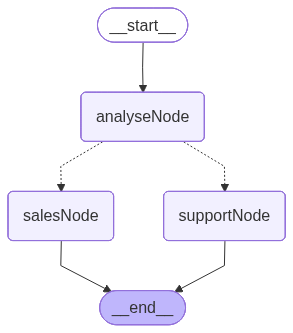

In [48]:
Image(customer_graph.get_graph().draw_mermaid_png())

In [49]:
def process_customer_message(customer_message: str):
    """Helper function to process a customer message through the graph"""
    print("=" * 50)
    print(f"PROCESSING CUSTOMER MESSAGE: {customer_message}")
    print("=" * 50)

    messages = [HumanMessage(content=f"""Analyze the following customer message and extract the requested information:        
    CUSTOMER MESSAGE: {customer_message}
    Please categorize this message and extract the relevant details.""")]
    
    initial_state = StructuredState(messages=messages,structured_output=None)
    
    result = customer_graph.invoke(initial_state)
    return result


In [50]:
test_messages = [
        """Hi, I saw your advert for the SmartCool KF3000 fridge and wanted to know if itcomes in black as well as silver? Also,
is there any current discount or free
delivery option available this week?""",
        """Our new HeatMaster CX900 cooker keeps shutting off mid-cycle and shows an E5 error on the screen. Can
you advise what that means or if we need an engineer visit?""",
        """I’m interested in buying a built-in
dishwasher for a small kitchen. I saw
the AquaWash D1200 model online —
do you have its dimensions and energy
rating details?""",
        """The BlendPro Mini B450 blender I
bought last month is leaking from the
base whenever I use it for smoothies.
Can I get a replacement jug or do I
need to send it in?""",
"""I’d like to compare the cooking
capacity between your WaveHeat
M700 microwave and the newer M710
model. Does the updated version have
a grill function or just reheat modes?"""
]
    
for i, message in enumerate(test_messages, 1):
    print(f"\n{'#' * 60}")
    print(f"TEST CASE {i}")
    print(f"{'#' * 60}")
    process_customer_message(message)
    print(f"\n{'#' * 60}")
    print("END OF TEST CASE")
    print(f"{'#' * 60}\n")


############################################################
TEST CASE 1
############################################################
PROCESSING CUSTOMER MESSAGE: Hi, I saw your advert for the SmartCool KF3000 fridge and wanted to know if itcomes in black as well as silver? Also,
is there any current discount or free
delivery option available this week?
SALES MESSAGE RECEIVED
Appliance: fridge
Models: ['KF3000']
Summary: Customer is asking if the SmartCool KF3000 fridge comes in black and if there are any discounts or free delivery options available this week.

############################################################
END OF TEST CASE
############################################################


############################################################
TEST CASE 2
############################################################
PROCESSING CUSTOMER MESSAGE: Our new HeatMaster CX900 cooker keeps shutting off mid-cycle and shows an E5 error on the screen. Can
you advise what that mean